In [1]:
import sys
import time
import os
import subprocess
import math
import matplotlib.pyplot as plt
import numpy as np
from astropy.table import Table, Column 
from scipy.stats import linregress
from scipy import interpolate
from scipy import polyval, polyfit
from scipy.optimize import curve_fit
from scipy import odr
import pylab as py
from matplotlib import gridspec
import sklearn.datasets as ds
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
import corner
import emcee
import scipy.optimize as op
from scipy.linalg import cholesky, inv,det
from scipy.optimize import minimize
import random
from astropy.table import Table, Column
from linear_mcmc import *

from redTools import *
from Kcorrect import *
from calibTools import *

In [2]:
I_maglim = [5807393, 5807403, 5057729, 5059653, 4126669, 5059227, 38803, 39181, 39431, 39619, 39655, 40005, 40107, 40147, 40588, 40604, 41567, 41829, 42768, 41440, 37814, 39344, 13756, 14548, 14590]
calib_maglim = [3974, 6699, 19871, 22277, 38148, 41020, 41066, 41093, 46127, 49448, 53641, 28378, 6699, 9962, 12460, 13163, 22277, 26761, 29128, 38148, 41020, 41066, 44982, 45084, 46127, 49448, 53641, 67908, 72228, 21102, 50073]


########### Updated list using the color-LogWimx correaltion


In [3]:
table   = np.genfromtxt('corrected_mags_linewidth_all.csv' , delimiter='|', 
                        filling_values=-1, names=True, dtype=None, encoding=None)

In [4]:
ctl   = np.genfromtxt('allzpa_labels.csv' , delimiter=',', filling_values=-1, 
                      names=True, dtype=None, encoding=None)
PGC  = ctl['PGC']
ID   = ctl['Name']
dist = 10**((ctl['dm19']-25)/5)  
manualInput_all = (PGC,ID,dist)

ctl   = np.genfromtxt('TFcal_ZP_trgb2.81.rizzi.csv' , delimiter=',', filling_values=-1, 
                      names=True, dtype=None, encoding=None)
PGC  = ctl['PGC']
ID   = ctl['Name']
dist = 10**((ctl['dmtriz']-25)/5) 
manualInput_rizzi = (PGC,ID,dist)



ctl   = np.genfromtxt('TFcal_ZP_cepheids2.33.csv' , delimiter=',', filling_values=-1, 
                      names=True, dtype=None, encoding=None)
PGC  = ctl['PGC']
ID   = ctl['Name']
dist = 10**((ctl['dmc19']-25)/5) 
manualInput_cepheids = (PGC,ID,dist)

manualInput = manualInput_cepheids


band = 'w1'
Clusters, slope0, zp0, slope_e0 = TF_iter(table, band = band, n_iter=10, verbose=False, 
                                            addSouth=True, pgcFaint=I_maglim)
print slope0, zp0

zp_calibs = all_ZP(table, band=band, slope=slope0, pgcFaint=calib_maglim, manualInput=manualInput)
slope = zp_calibs['slope']
zp    = zp_calibs['zp']
zp_e = zp_calibs['zp_e']
print slope0, slope_e0, slope, zp

-9.472804095041074 -0.0014542577354796618
Using the manual ZP file ... .
-9.472804095041074 0.1420617834915643 -9.472804095041074 -20.394949276984693


3.0497674989286665 NEST_200003 A262
3.1632469910192142 NEST_200005 N410
3.195508137946872 NEST_200006 N507
3.352260904532546 NEST_100030 Cancer
3.647958468465875 NEST_200045 N80
3.7261086806764165 NEST_200037 N70
4.050282815270343 NEST_100005 A1367
4.053369642278074 NEST_100001 Coma
4.098126031895131 NEST_200012 A400
4.264816558961046 NEST_100018 N4065
4.417921429486579 NEST_200017 A539
4.484533978020641 NEST_200016 A2634/66
5.243476417736245 NEST_100007 Hercules
0 NEST_100002 Virgo
0.3538646186006815 NEST_100008 UMa
0.4140399410560658 NEST_200015 Fornax
1.834804566202001 NEST_100003 Centaurus
1.980785694159783 NEST_100014 Antlia
2.368864293465691 NEST_200092 Pegasus
2.863244812903419 NEST_100006 Hydra


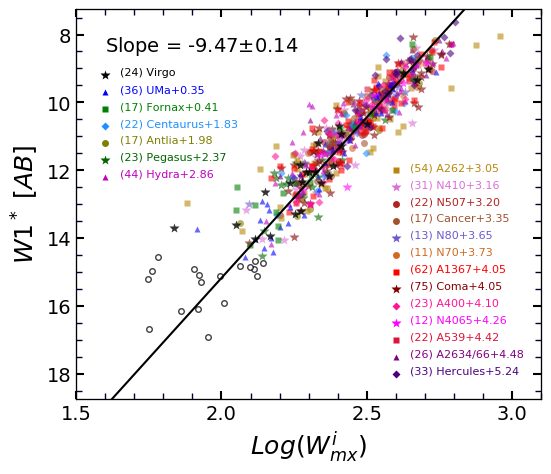

In [5]:
dye = {"u":"blue","g":"green","r":"red","i":"orange","z":"maroon","w1":"purple", 'w2': "brown"}
cmap = get_cmap(21)
fig, ax, x_ax, y_ax = makeFig(band=band, xLim = (1.5,3.1), yLim = (18.75,7.25), MAGabs=False, getTwinAX=True)

key0 = 'NEST_100002'
myCluster = Clusters[key0]
zp_virgo = myCluster['zp']
I_mag = myCluster['mag']
logWimx = myCluster['logWimx']
pgc_ = myCluster['pgc']


symcol = {}
symcol['NEST_100002']=['Virgo', '*', 'black']
symcol['NEST_100008']=['UMa', '^', 'blue']
symcol['NEST_200015']=['Fornax', 's', 'green']
symcol['NEST_100003']=['Centaurus', 'D', 'dodgerblue']
symcol['NEST_100014']=['Antlia', '.', 'olive']
symcol['NEST_200092']=['Pegasus', '*', 'darkgreen']
symcol['NEST_100006']=['Hydra', '^', 'm']
symcol['NEST_200003']=['A262', 's', 'darkgoldenrod']
symcol['NEST_200005']=['N410', '*', 'orchid']
symcol['NEST_200006']=['N507', '.', 'firebrick']
symcol['NEST_100030']=['Cancer', '.', 'sienna']
symcol['NEST_200045']=['N80', '*', 'slateblue']
symcol['NEST_200037']=['N70', '.', 'chocolate']
symcol['NEST_100005']=['A1367', 's', 'red']
symcol['NEST_100001']=['Coma', '*', 'maroon']
symcol['NEST_200012']=['A400', 'D', 'deeppink']
symcol['NEST_100018']=['N4065', '*', 'magenta']
symcol['NEST_200017']=['A539', 's', 'crimson']
symcol['NEST_200016']=['A2634/66', '^', 'purple']
symcol['NEST_100007']=['Hercules', 'D', 'indigo']



key_lst = []
d_lst = []
n_lst =[]
for i, key in enumerate(Clusters):
    
    if key!=key0:
        
        myCluster = Clusters[key]
        pgc = myCluster['pgc']
        zp_ = myCluster['zp']
        I_mag = myCluster['mag']-zp_+zp_virgo
        logWimx = myCluster['logWimx']
        
        key_lst.append(key)
        d_lst.append(zp_-zp_virgo)
        
        
        if symcol[key][1]=='*':
            size = 7
        elif symcol[key][1]=='D':
            size = 4    
        elif symcol[key][1]=='s':
            size = 4           
        elif symcol[key][1]=='^':
            size = 5   
        elif symcol[key][1]=='.':
            size = 10   

        indx = []
        indx_ = []    
        for i, id in enumerate(pgc):
            if not id in I_maglim:
                indx.append(i)
            else:
                indx_.append(i)             
            
        n_lst.append(len(logWimx[indx]))
        ax.plot(logWimx[indx], I_mag[indx], symcol[key][1], color=symcol[key][2], alpha=0.6, 
                markersize=size, markeredgecolor='none')
        ax.plot(logWimx[indx_], I_mag[indx_], 'ko', alpha=0.75, markersize=4, mfc='white')
        
        

myCluster = Clusters[key0]
I_mag = myCluster['mag']
logWimx = myCluster['logWimx']
pgc = myCluster['pgc']
indx = []
indx_ = []    
for i, id in enumerate(pgc):
    if not id in I_maglim:
        indx.append(i)
    else:
        indx_.append(i)  
key_lst.append(key0)
d_lst.append(0)
n_lst.append(len(logWimx[indx]))
ax.plot(logWimx[indx], I_mag[indx], symcol[key0][1], color=symcol[key0][2], alpha=0.8,
        markersize=7, markeredgecolor='none')
ax.plot(logWimx[indx_], I_mag[indx_], 'ko', alpha=0.75, markersize=4, mfc='white')
        


        

Ylm = ax.get_ylim() ; Xlm = ax.get_xlim()

ax.text(1.6,8.5, "Slope = "+"%.2f" % slope0+'$\pm$'+"%.2f" % slope_e0, fontsize=14, color='k')

ax.set_xticks(np.arange(1.5,3.5, step=0.5))
x_ax.set_xticks(np.arange(1.5,3.5, step=0.5))

x = np.linspace(-5,5,50)
y = slope*(x-2.5)+zp_virgo
ax.plot(x,y, 'k-')

indx  = np.argsort(d_lst)

p = 0 
for i in indx[7:]:
    key = key_lst[i]
    print d_lst[i], key_lst[i], symcol[key][0]
    
    if symcol[key][1]=='*':
        size = 7
    elif symcol[key][1]=='D':
        size = 4    
    elif symcol[key][1]=='s':
        size = 4           
    elif symcol[key][1]=='^':
        size = 5   
    elif symcol[key][1]=='.':
        size = 10       

    label = '(%d) '%n_lst[i]+symcol[key][0]+'+'+'%.2f'%d_lst[i]
    if key==key0: label = '(%d) '%n_lst[i]+symcol[key][0]
    
    ax.plot([2.60],[12+0.5*p], symcol[key][1], color=symcol[key][2], alpha=1, 
                markersize=size, markeredgecolor='none')
    ax.text(2.65,12+0.5*p, label, fontsize=8, color=symcol[key][2])
    p+=1

    
p = 0 
for i in indx[0:7]:
    key = key_lst[i]
    print d_lst[i], key_lst[i], symcol[key][0]
    
    if symcol[key][1]=='*':
        size = 7
    elif symcol[key][1]=='D':
        size = 4    
    elif symcol[key][1]=='s':
        size = 4           
    elif symcol[key][1]=='^':
        size = 5   
    elif symcol[key][1]=='.':
        size = 10       

    label = '(%d) '%n_lst[i]+symcol[key][0]+'+'+'%.2f'%d_lst[i]
    if key==key0: label = '(%d) '%n_lst[i]+symcol[key][0]
    
    ax.plot([1.6],[9.2+0.5*p], symcol[key][1], color=symcol[key][2], alpha=1, 
                markersize=size, markeredgecolor='none')
    ax.text(1.65,9.2+0.5*p, label, fontsize=8, color=symcol[key][2])
    p+=1

In [6]:
def rmsMaker(logWimx, mag, logWimx_e, slope, zp, pgc=None):
    

#     indx, = np.where(mag<-18)    
#     logWimx = logWimx[indx]
#     mag = mag[indx]
#     logWimx_e = logWimx_e[indx]
#     print pgc[indx]
    N = len(mag)
    indx = np.arange(N)

    
    mag_fit = slope*(logWimx-2.5)+zp
#     rms = np.sqrt(np.mean((mag-mag_fit)**2))
    delta = mag-mag_fit

    Y_fit2 = delta
    std = np.sqrt(np.mean((Y_fit2)**2))
    indx, = np.where(Y_fit2<3*std)
    Y_fit1 = Y_fit2[indx]
    indx, = np.where(Y_fit1>-3*std)
    Y_fit2 = Y_fit1[indx]

    std = np.sqrt(np.mean((Y_fit2)**2))
    indx, = np.where(Y_fit2<3*std)
    Y_fit1 = Y_fit2[indx]
    indx, = np.where(Y_fit1>-3*std)
    Y_fit2 = Y_fit1[indx]

    std = np.sqrt(np.mean((Y_fit2)**2))
    indx, = np.where(Y_fit2<3*std)
    Y_fit1 = Y_fit2[indx]
    indx, = np.where(Y_fit1>-3*std)
    Y_fit2 = Y_fit1[indx]

    std = np.sqrt(np.mean((Y_fit2)**2))
    indx, = np.where(Y_fit2<3*std)
    Y_fit1 = Y_fit2[indx]
    indx, = np.where(Y_fit1>-3*std)
    Y_fit2 = Y_fit1[indx]


    N = len(Y_fit2)
    rms =  np.sqrt(np.sum(Y_fit2**2)/(N-1))    
    
    
    
    
    logWimx_f = (mag-zp)/slope+2.5
    RMS = np.abs(slope*(np.sqrt(np.sum((logWimx-logWimx_f)**2/logWimx_e**2)/np.sum(1./logWimx_e**2))))
    
    return rms, RMS

-9.472804095041074 -20.394949276984693
w1 29 -20.39 0.08 0.47 0.41


Text(1.58,-20.7,'Cepheid Calibrators')

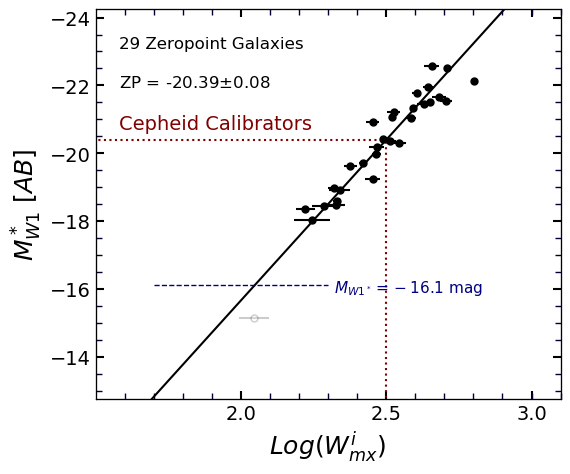

In [7]:
fig, ax, x_ax, y_ax = makeFig(band=band, xLim = (1.5,3.1), yLim = (-12.75,-24.25), MAGabs=True, getTwinAX=True)



# plotCluster(ax, zp_calibs, offset=0, plotErrors=False, alpha=0.7, 
#             markersize=0, plotFit=True, pgcFaint=I_maglim)

m0 = zp_calibs['slope']
b0 = zp_calibs['zp']
dm0 = zp_calibs['slope_e']
db0 = zp_calibs['zp_e']
mag_ = zp_calibs['MAG']
logWimx_ = zp_calibs['logWimx']
mag_e = zp_calibs['mag_e']
logWimx_e = zp_calibs['logWimx_e']
pgc = zp_calibs['pgc']

mag_w = zp_calibs['MAG_w']
logWimx_w = zp_calibs['logWimx_w']
mag_e_w = zp_calibs['mag_e_w']
logWimx_e_w = zp_calibs['logWimx_e_w']

dye = {"u":"blue","g":"green","r":"red","i":"orange","z":"maroon","w1":"purple", 'w2': "brown"}


indx = []
indx_ = []    
for i, id in enumerate(pgc):
    if not id in calib_maglim:
        indx.append(i)
    else:
        indx_.append(i)  


ax.errorbar(logWimx_[indx], mag_[indx], fmt='o',  
                        markersize=5,
                    xerr=logWimx_e[indx], color = 'k')

ax.errorbar(logWimx_w, mag_w, fmt='o',  
                        markersize=5,
                    xerr=logWimx_e_w, yerr=mag_e_w, color = 'k', alpha=0.2, markerfacecolor='white')

if len(indx_)>0:
            ax.errorbar(logWimx_[indx_], mag_[indx_], fmt='o',  
                    xerr=logWimx_e[indx_], color='k', markersize=5, alpha=0.2, markerfacecolor='white')


x = np.linspace(-5,5,50)
y = slope*(x-2.5)+zp
ax.plot(x,y, 'k-')  

x0 = 2.5
y0 = 100
x1 = 2.5
y1 = slope*(x1-2.5)+zp
ax.plot([x0,x1],[y0,y1], ':', color='maroon') 

x2 = -5
y2 = y1
x3 = x1
y3 = y1
ax.plot([x2,x3],[y2,y3], ':', color='maroon')   



print m0, b0
N = len(logWimx_[indx])


Ylm = ax.get_ylim() ; Xlm = ax.get_xlim()
x0 = 0.95*Xlm[0]+0.05*Xlm[1]
y0 = 0.1*Ylm[0]+0.90*Ylm[1]
ax.text(x0,y0, "%d" % N+' Zeropoint Galaxies', fontsize=12, color='k')
y0 = 0.2*Ylm[0]+0.80*Ylm[1]
ax.text(x0,y0, "ZP = "+"%.2f" % b0+'$\pm$'+"%.2f" % db0, fontsize=12, color='k')


rms,RMS = rmsMaker(logWimx_[indx], mag_[indx], logWimx_e[indx], slope, zp, pgc=pgc[indx])
print band, N, '%.2f'%b0, '%.2f'%db0[0], '%.2f'%rms, '%.2f'%RMS


if band=='i':
    x = np.linspace(1.7,2.4,20)
    ax.plot(x,-17*x/x,'--', lw=1, color='navy')
    ax.text(2.45,-16.8, r'$M_{i^*}=-17$'+' mag', fontsize=11, color='navy')

if band=='w1':
    x = np.linspace(1.7,2.3,20)
    ax.plot(x,-16.1*x/x,'--', lw=1, color='navy')
    ax.text(2.32,-15.9, r'$M_{W1^*}=-16.1$'+' mag', fontsize=11, color='navy')

ax.text(x0,-20.7, "Cepheid Calibrators", fontsize=14, color='maroon')

In [8]:
print slope, zp

-9.472804095041074 -20.394949276984693


In [9]:
d_lst = []
de_lst = []
keys = []
for i, key in enumerate(Clusters):
        myCluster = Clusters[key]
        #print key, myCluster['slope'], myCluster['zp']-zp
        
        d_modulus = myCluster['zp']-zp
        d_modulus_e = myCluster['zp_e']
        d_lst.append(d_modulus)
        de_lst.append(d_modulus_e)
        keys.append(key)

print 

indx  = np.argsort(d_lst)

   
    
for i in indx:
    key = keys[i]
    myCluster = Clusters[key]
    
    pgc = myCluster['pgc']
    indx = []
    indx_ = []    
    for jj, id in enumerate(pgc):
        if not id in I_maglim:
            indx.append(jj)
        else:
            indx_.append(jj)      
    
    
    print myCluster['name']+ ' & w1 &  & '+'%d'%len(pgc[indx])+' & '+'%.2f'%d_lst[i]+ ' & '+'%.2f'%de_lst[i][0]
    


Virgo & w1 &  & 24 & 30.84 & 0.10
Ursa Major & w1 &  & 36 & 31.19 & 0.08
Fornax & w1 &  & 17 & 31.25 & 0.14
Centaurus & w1 &  & 22 & 32.67 & 0.13
Antlia & w1 &  & 17 & 32.82 & 0.11
Pegasus & w1 &  & 23 & 33.21 & 0.12
Hydra & w1 &  & 44 & 33.70 & 0.10
Abell 262 & w1 &  & 54 & 33.89 & 0.13
NGC410 & w1 &  & 31 & 34.00 & 0.10
NGC507 & w1 &  & 22 & 34.03 & 0.08
Cancer & w1 &  & 17 & 34.19 & 0.11
NGC80 & w1 &  & 13 & 34.48 & 0.12
NGC70 & w1 &  & 11 & 34.56 & 0.12
Abell 1367 & w1 &  & 62 & 34.89 & 0.06
Coma & w1 &  & 75 & 34.89 & 0.06
Abell 400 & w1 &  & 23 & 34.93 & 0.08
NGC4065 & w1 &  & 12 & 35.10 & 0.11
Abell 539 & w1 &  & 22 & 35.25 & 0.08
Abell 2634/66 & w1 &  & 26 & 35.32 & 0.08
Abell 2151 (Hercules) & w1 &  & 33 & 36.08 & 0.09
